In [12]:
import torch
from torch import nn
import d2l_torch as d2l

+ nn.Conv2d()中stride默认为1，padding默认为0
+ Maxpool2d中，stride默认等于kernel_size,padding默认为0，dilation=1

# 正常的NiN

## NiN块

In [13]:
def nin_block(in_channels,out_channels,kernel_size,stride,padding):
    sub_net=nn.Sequential(
    nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),nn.ReLU(),
    nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU(),
    nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU())
    return sub_net

+ NiN其实借鉴了AlexNet的块的思想，所以设计上很像AlexNet
+ 下面每个NiN块第一个卷积层的输出通道数，其实是对照AlexNet进行设置的。(只用了AlexNet的前三个卷积层，后面那几个成堆的卷积层没使用)

In [16]:
# target output size of 5x7
m = nn.AdaptiveAvgPool2d((5,7))
input = torch.randn(1, 64, 8, 9)
output = m(input)
print(output.shape)

# target output size of 7x7 (square)
m = nn.AdaptiveAvgPool2d(7)
input = torch.randn(1, 64, 10, 9)
output = m(input)
print(output.shape)

# target output size of 10x7
m = nn.AdaptiveAvgPool2d((None, 7))
input = torch.randn(1, 64, 10, 9)
output = m(input)
print(output.shape)

torch.Size([1, 64, 5, 7])
torch.Size([1, 64, 7, 7])
torch.Size([1, 64, 10, 7])


## NinNet


In [3]:
net=nn.Sequential(
    nin_block(1,96,kernel_size=11,stride=4,padding=0),
    nn.MaxPool2d(kernel_size=3,stride=2),  # (n+2p+s-k)/2(=n+2-3)/2=(n-1)/2,输出的feature map比上面小1，但是通道个数不变，每个通道的大小减1
    nin_block(96,256,kernel_size=5,stride=1,padding=2), # p=(k-1)/2 所以输出的大小不变 strides=1本来就是默认
    nn.MaxPool2d(kernel_size=3,stride=2),
    nin_block(256,384,kernel_size=3,stride=1,padding=1), # p=(k-1)/2 所以输出的大小不变 strides=1本来就是默认
    nn.MaxPool2d(kernel_size=3,stride=2),nn.Dropout(0.5),
    nin_block(384,10,kernel_size=3,stride=1,padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten())

**注意，步幅这个参数就是 stride，没有s，不是strides，padding都不是paddings，沐神的代码在nin_block的形参里写的是strides，其实有问题**

上面代码其实有两个地方要注意
1. 那个dropout是怎么弄的，不是只有全连接层可以dropout，虽然那个1x1卷积层也算一个全连接层，但是这个dropout只在最后一个nin_block之前
2. 那个AdaptiveAvgPool2d输出的内容/维度，需要压平才可以出去计算？？

In [7]:
X=torch.rand((1,1,224,224))
for layer in net:
    if layer.__class__.__name__=="Sequential":
        for sub_layer in layer:
            X=sub_layer(X)
            print(sub_layer.__class__.__name__,"output shape: \t",X.shape)
    else:
        X=layer(X)
    print(layer.__class__.__name__,"output shape: \t",X.shape)

Conv2d output shape: 	 torch.Size([1, 96, 54, 54])
ReLU output shape: 	 torch.Size([1, 96, 54, 54])
Conv2d output shape: 	 torch.Size([1, 96, 54, 54])
ReLU output shape: 	 torch.Size([1, 96, 54, 54])
Conv2d output shape: 	 torch.Size([1, 96, 54, 54])
ReLU output shape: 	 torch.Size([1, 96, 54, 54])
Sequential output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape: 	 torch.Size([1, 96, 26, 26])
Conv2d output shape: 	 torch.Size([1, 256, 26, 26])
ReLU output shape: 	 torch.Size([1, 256, 26, 26])
Conv2d output shape: 	 torch.Size([1, 256, 26, 26])
ReLU output shape: 	 torch.Size([1, 256, 26, 26])
Conv2d output shape: 	 torch.Size([1, 256, 26, 26])
ReLU output shape: 	 torch.Size([1, 256, 26, 26])
Sequential output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape: 	 torch.Size([1, 256, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	 torch.Size([1, 384, 12, 12])
Conv2d output shape: 	 torch.Size([1, 384, 12, 12])
ReLU output shape: 	

In [8]:
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (3): ReLU()
    (4): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1))
    (5): ReLU()
  )
  (5): MaxPool2d(kernel_size=3, stri

In [16]:
X=torch.rand((1,1,224,224))
for layer in net:
    X=layer(X)
    print(layer.__class__.__name__,"output shape: \t",X.shape)

Sequential output shape: 	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape: 	 torch.Size([1, 96, 26, 26])
Sequential output shape: 	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape: 	 torch.Size([1, 256, 12, 12])
Sequential output shape: 	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape: 	 torch.Size([1, 384, 5, 5])
Dropout output shape: 	 torch.Size([1, 384, 5, 5])
Sequential output shape: 	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape: 	 torch.Size([1, 10, 1, 1])
Flatten output shape: 	 torch.Size([1, 10])


+ AdaptiveAvgPool2d output shape: 	 torch.Size([1, 10, 1, 1])
+ 上面这句其实就是，不管通道大小是多大，把这个通道的平均值拿出来。一共是$1\times 10$个通道，每个通道大小/feature map都是$5\times 5$

## 训练模型

loss 0.370, train acc 0.863, test acc 0.868
480.9 examples/sec on cuda:0


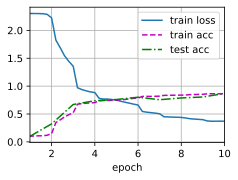

In [4]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 去掉一个1x1卷积

In [9]:
def nin_block_small(in_channels,out_channels,kernel_size,stride,padding):
    sub_net=nn.Sequential(
    nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding),nn.ReLU(),
    nn.Conv2d(out_channels,out_channels,kernel_size=1),nn.ReLU())
    return sub_net

In [10]:
net_small=nn.Sequential(
    nin_block_small(1,96,kernel_size=11,stride=4,padding=0),
    nn.MaxPool2d(kernel_size=3,stride=2),  # (n+2p+s-k)/2(=n+2-3)/2=(n-1)/2,输出的feature map比上面小1，但是通道个数不变，每个通道的大小减1
    nin_block_small(96,256,kernel_size=5,stride=1,padding=2), # p=(k-1)/2 所以输出的大小不变 strides=1本来就是默认
    nn.MaxPool2d(kernel_size=3,stride=2),
    nin_block_small(256,384,kernel_size=3,stride=1,padding=1), # p=(k-1)/2 所以输出的大小不变 strides=1本来就是默认
    nn.MaxPool2d(kernel_size=3,stride=2),nn.Dropout(0.5),
    nin_block(384,10,kernel_size=3,stride=1,padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten())

loss 0.346, train acc 0.872, test acc 0.868
636.7 examples/sec on cuda:0


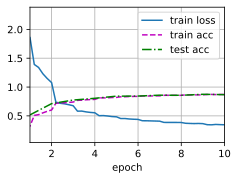

In [11]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net_small, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())